**MFCC**

In [12]:
import os ##libreria para la lectura de archivos del sistema operativo
import numpy as np # libreria para la creacion y procesamiento de arreglos numpy 
import scipy # modulo para el procesamiento de informacion contenida en matrices 
from scipy.io import wavfile # modulo para la lectura de archivo .wav
import scipy.fftpack as fft # funciones para aplicar la transformada rapida de Fourier
from scipy.signal import get_window 
import IPython.display as ipd # libreria para visualizar un reproductor para lectura de audios
import matplotlib.pyplot as plt #librearia para la creacion de graficos. 
import librosa #libreria para el analisis de audios.

**Se extraeran los archivos de voz con formato .mp3 desde google drive.**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**1. Lectura de los archivos de audio**

**Se convertiran los archivos al formato .wav**

In [8]:
pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
from pydub import AudioSegment # funcion para cambiar el formato de un audio 

Ejemplo de conversion para un audio en formato .wav

In [ ]:
m4a_file = './drive/MyDrive/reco_voz_dataset_test/11.m4a'
wav_filename = r'./drive/MyDrive/reco_voz_dataset_test/wavs/test/11.wav'
track = AudioSegment.from_file(m4a_file,  format= 'm4a')
file_handle = track.export(wav_filename, format='wav')

In [ ]:
TRAIN_PATH = './drive/MyDrive/reco_voz_dataset_test/wavs/'
WAV_SAMPLE_FILE=TRAIN_PATH + "14.wav"
print(type(WAV_SAMPLE_FILE))
ipd.Audio(WAV_SAMPLE_FILE)

<class 'str'>


Ejemplo de conversion para un audio en formato .mp3

In [10]:
file_name='32'
mp3_file = './drive/MyDrive/rv_dataset_mp3/3/'+file_name+'.mp3'
wav_filename = r'./drive/MyDrive/rv_dataset_wav/3/'+file_name+'.wav'
track = AudioSegment.from_file(mp3_file,  format= 'mp3')
file_handle = track.export(wav_filename, format='wav')

In [13]:
ipd.Audio("./drive/MyDrive/rv_dataset_wav/3/32.wav")

Lectura de freciencia del audio

In [ ]:
TRAIN_PATH = './drive/MyDrive/rv_dataset_wav/'
WAV_SAMPLE_FILE=TRAIN_PATH + "2/22.wav"

In [ ]:
sample_rate, audio = wavfile.read(WAV_SAMPLE_FILE)
print("Sample rate: {0}Hz".format(sample_rate))
print("Audio duration: {0}s".format(len(audio) / sample_rate))
print(audio.shape)
## vector a partir del cual se pueda obtener sus coeficientes muestrales

Sample rate: 48000Hz
Audio duration: 0.5049791666666666s
(24239, 2)


In [ ]:
audio_fil, frecuency = librosa.load( WAV_SAMPLE_FILE, sr=41000)
print(audio_fil.shape)

(20705,)


**Normalización**

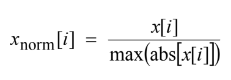

In [ ]:
def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio

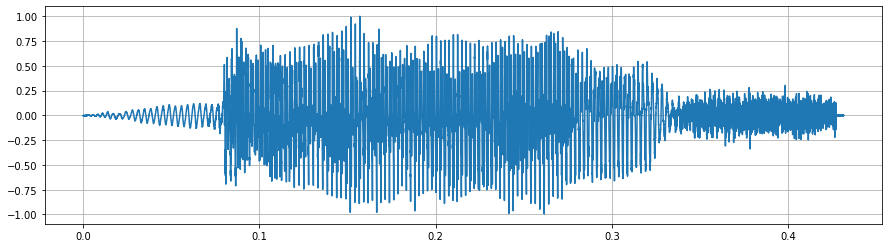

In [ ]:
audio = normalize_audio(audio_fil)
plt.figure(figsize=(15,4))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.grid(True)

**Encuadre del audio**

Se dividira el audio en frames, que sigan con valores estacionarios o continuos
llevar la frecuencia del audio a valores discretos y continuos 

In [ ]:
def frame_audio(audio, FFT_size=2048, hop_size=10, sample_rate=44100):
    print("------------------ANTES------------")
    print(audio)
    print(audio.shape)
    print("--------------DESPUES----------------")
    audio = np.pad(audio, int(FFT_size / 2), mode='reflect') # agrega a la matriz audio con la mistad del tamaño de la transormada de fourier 
    print("audio matriz: ")
    print(audio)
    print(audio.shape)
    print("----------------------------------")
    frame_len = np.round(sample_rate * hop_size / 1000).astype(int)  # redondear 

    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    print("frame_num: ")
    print(frame_num)

    frames = np.zeros((frame_num,FFT_size))
    
    for n in range(frame_num):
        frames[n] = (audio[n*frame_len:n*frame_len+FFT_size])

    return frames

In [ ]:
hop_size = 5
FFT_size = 2048
sample_rate=44100

audio_framed = frame_audio(audio, FFT_size=FFT_size, hop_size=hop_size, sample_rate=sample_rate)
print("Framed audio shape: {0}".format(audio_framed.shape))

------------------ANTES------------
[-0.00249459 -0.00372859 -0.00246757 ... -0.00201075  0.0006061
  0.        ]
(20705,)
--------------DESPUES----------------
audio matriz: 
[ 0.01113395  0.01189818  0.01235674 ... -0.05648703  0.02802739
  0.01834667]
(22753,)
----------------------------------
frame_num: 
95
Framed audio shape: (95, 2048)


----------------------------------------------

In [ ]:
print("First frame:")
audio_framed[1]

First frame:


array([ 0.01355481,  0.01355186,  0.01166622, ..., -0.03239598,
       -0.03397812, -0.03393679])

In [ ]:
print("Last frame:")
audio_framed[-1]

Last frame:


array([-0.09607759, -0.07242709,  0.0527877 , ..., -0.07961993,
       -0.07670175,  0.05776529])

**Convertir al dominio de la frecuencia**

conversion del audio en dominio del tiempo a la frecuencia , se aplicara el enventanado a cada frame obtenido, en casos de no enventanar los frames el entrenamiento tendra un error alto sin poder adaptarse a distorsiones.

Como resultado terminara cercana a 0

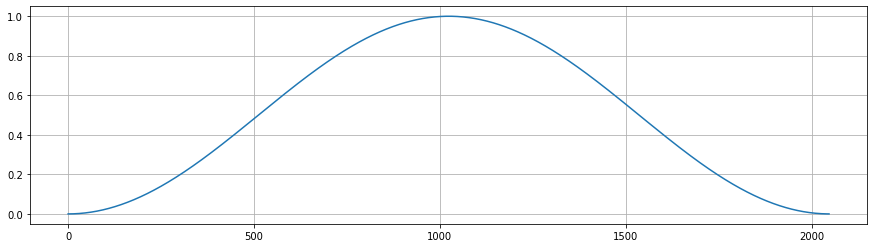

In [ ]:
window = get_window("hann", FFT_size, fftbins=True)
plt.figure(figsize=(15,4))
plt.plot(window)
plt.grid(True)

[[ 0.00000000e+00  2.79975603e-08  1.16306064e-07 ...  2.77972195e-07
   1.16306064e-07  2.79975603e-08]
 [ 0.00000000e+00  3.18888281e-08  1.09806636e-07 ... -6.86073229e-07
  -3.19814249e-07 -7.98565007e-08]
 [-0.00000000e+00 -3.20547218e-08 -1.05581451e-07 ... -1.67194745e-07
  -7.04956453e-08 -1.77166912e-08]
 ...
 [ 0.00000000e+00  7.67347485e-08 -6.68461083e-07 ...  1.73015818e-07
   1.43880966e-07 -2.41156282e-08]
 [ 0.00000000e+00 -3.22673056e-07 -9.89016861e-07 ...  1.41238529e-06
  -8.54665052e-07 -4.63630999e-07]
 [-0.00000000e+00 -1.70427831e-07  4.96856791e-07 ... -1.68616889e-06
  -7.21944340e-07  1.35927219e-07]]


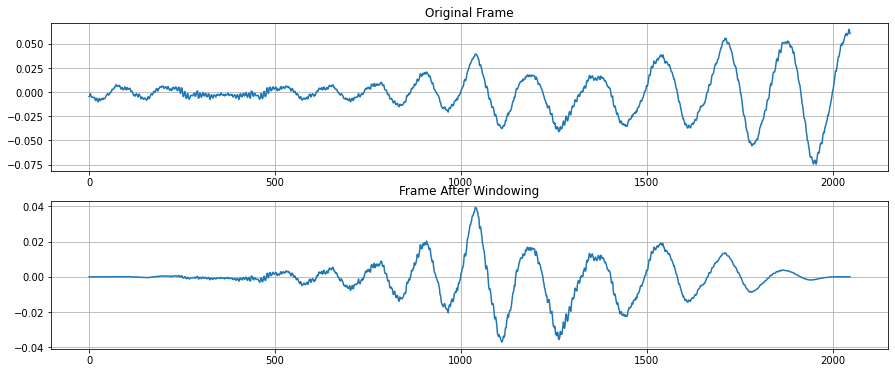

In [ ]:
##para los frames contenidos en el intervalo de 0 a 4 segundos
audio_win = audio_framed * window
print (audio_win)
ind = 3
plt.figure(figsize=(15,6))
plt.subplot(2, 1, 1)
plt.plot(audio_framed[ind])
plt.title('Original Frame')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(audio_win[ind])
plt.title('Frame After Windowing')
plt.grid(True)

Esta informacion nos permitira entrenar a la red neuronal con menor error de prediccion

**Transormada rapida de Fourier**

In [ ]:
audio_winT = np.transpose(audio_win)

audio_fft = np.empty((int(1 + FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')

for n in range(audio_fft.shape[1]):
    audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]

audio_fft = np.transpose(audio_fft)

Calcilo del signal power para obtener la informacion mas relevante

In [ ]:
audio_power = np.square(np.abs(audio_fft))
print(audio_power.shape)

(95, 1025)


**Filtro de bancos de MEL**

Se creara el filtro de bancos del espacio de MEL, luego se pasara el audio enventanado, lo que nos dara la frecuencia relevante para cada frame.





In [ ]:
freq_min = 0
freq_high = sample_rate / 2
mel_filter_num = 10

print("Minimum frequency: {0}".format(freq_min))
print("Maximum frequency: {0}".format(freq_high))

Minimum frequency: 0
Maximum frequency: 22050.0


Construccion de los puntos de los filtros para determinar el inicio y el fin.
Construccion de un arreglo lineal entre los dos extremos
convertir el arreglo al espacio de frecuencias 
Normalizacion del arreglo correspondiente con el tamaño de la transformada de Fourier.

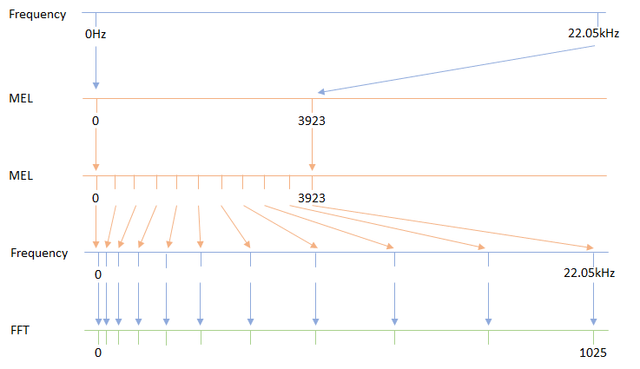


In [ ]:
def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def met_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

In [ ]:
def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=44100):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    
    print("MEL min: {0}".format(fmin_mel))
    print("MEL max: {0}".format(fmax_mel))
    
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = met_to_freq(mels)
    print(np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs)
    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs

In [ ]:
filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, sample_rate=44100)
filter_points

MEL min: 0.0
MEL max: 3923.337321740179
[   0   12   28   51   82  125  184  265  376  528  737 1024] [    0.           260.59867204   618.21401246  1108.96375691
  1782.4116895   2706.57338913  3974.785534    5715.13253718
  8103.38256596 11380.73943188 15878.20322216 22050.        ]


array([   0,   12,   28,   51,   82,  125,  184,  265,  376,  528,  737,
       1024])

Teniendo los puntos de filtros, se contruiran los filtros

In [ ]:
def get_filters(filter_points, FFT_size):
    filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    
    return filters

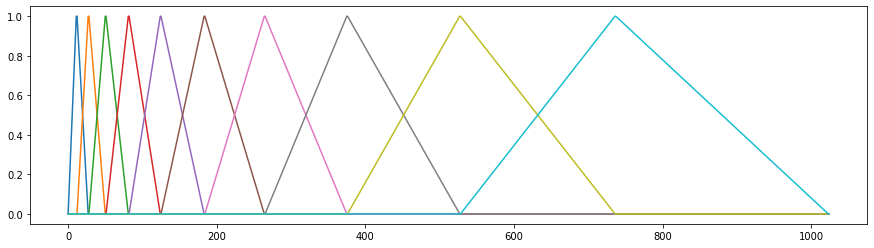

In [ ]:
filters = get_filters(filter_points, FFT_size)

plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

A continuación, dividimos los pesos MEL triangulares por el ancho de la banda MEL (normalización del área). Si no normalizamos los filtros, veremos que el ruido aumenta con la frecuencia debido al ancho del filtro.

In [ ]:
enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
filters *= enorm[:, np.newaxis]

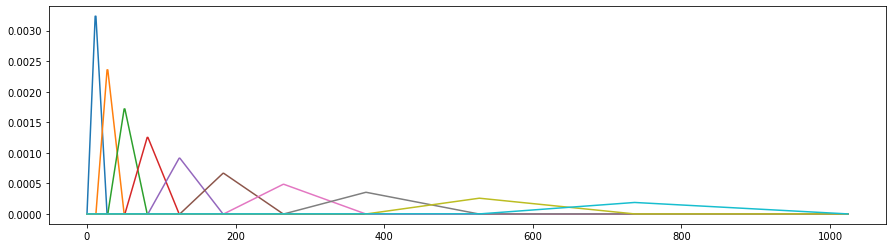

In [ ]:
plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

**Filtros de señal**

In [ ]:
audio_filtered = np.dot(filters, np.transpose(audio_power))
audio_log = 10.0 * np.log10(audio_filtered)
audio_log.shape

(10, 95)

**Generacion de los coeficientes ceptrales**

se utilizara la transformada de coseno discreta, la DCT-III extrae las altas frecuentcias y los cambios en las bajas frecuencias

In [ ]:
def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)
    
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
        
    return basis

In [ ]:
dct_filter_num = 40

dct_filters = dct(dct_filter_num, mel_filter_num)
# la señal filtrada por los filtros
cepstral_coefficents = np.dot(dct_filters, audio_log)
print(cepstral_coefficents.shape)

(40, 95)


In [ ]:
cepstral_coefficents[:, 24]

array([ 7.11269355e+00,  3.84293883e+01, -6.62941816e+00, -2.32118243e+00,
       -3.63945337e-01, -7.04719529e+00,  1.20624047e+00, -1.54028430e+00,
       -4.09214327e+00,  2.17257660e+00,  4.07131433e-14, -2.17257660e+00,
        4.09214327e+00,  1.54028430e+00, -1.20624047e+00,  7.04719529e+00,
        3.63945337e-01,  2.32118243e+00,  6.62941816e+00, -3.84293883e+01,
       -1.00588677e+01, -3.84293883e+01,  6.62941816e+00,  2.32118243e+00,
        3.63945337e-01,  7.04719529e+00, -1.20624047e+00,  1.54028430e+00,
        4.09214327e+00, -2.17257660e+00, -5.25889001e-14,  2.17257660e+00,
       -4.09214327e+00, -1.54028430e+00,  1.20624047e+00, -7.04719529e+00,
       -3.63945337e-01, -2.32118243e+00, -6.62941816e+00,  3.84293883e+01])

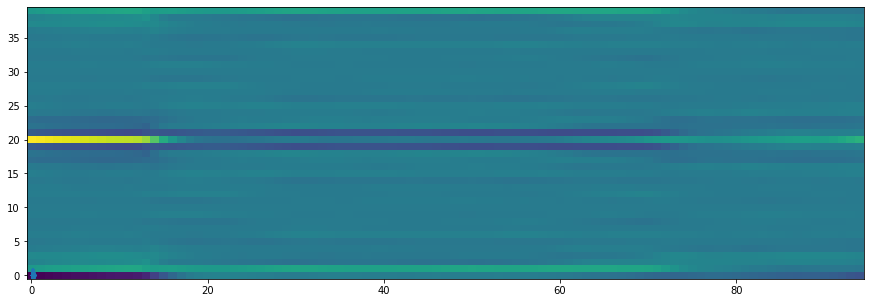

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.imshow(cepstral_coefficents, aspect='auto', origin='lower');

In [14]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.io import wavfile
import librosa # libreria para el analisis de audios
import librosa.display # modulo de visualizacion basado en matplotlib
import librosa.feature # modulo para la extraccion y manipulacion de caracteristicas
import glob # permite la busqueda de rutas y ficheros que coincidan con un patron especifico

from keras.models import Sequential # modelo sequencial para una red neuronal
from keras.layers import Dense,Activation # y=(x*w+bi) y funcion de activacion
from keras.utils.np_utils import to_categorical # convierte un vector de clases a una matriz

import warnings
warnings.filterwarnings('ignore')

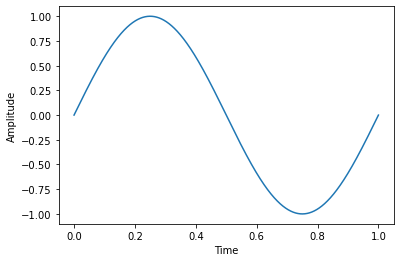

In [15]:
# simple sine wave
A = 1                     # Amplitude
f0 = 1                    # frequency
Fs = 41000                # Sampling frequency
t = np.arange(0, 1, 1/Fs) # crea una matriz de valores entre un intervalo determinado

X = A * np.sin(2 * np.pi * f0 * t)

plt.plot(t, X)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

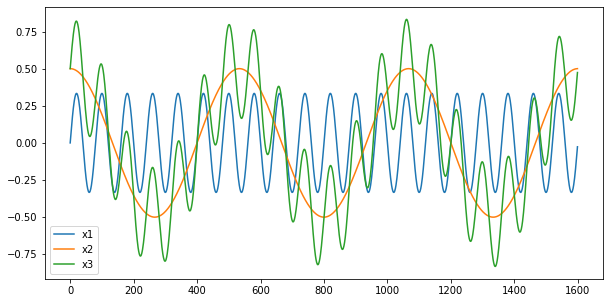

In [16]:
# create two independent waves then adding them resulting wave is complex wave.

# wave 1
A = 1/3
f0 = 20
Fs = 1600
t = np.arange(0, 1, 1/Fs)
X1 = A * np.sin(2  * np.pi * f0 * t)

# wave 2
A = 0.5
f0 = 3
Fs = 1600
t = np.arange(0, 1, 1/Fs)
X2 = A * np.cos(2  * np.pi * f0 * t)

# wave 3 = wave 1 + wave 2
X3 = X1 + X2


plt.figure(figsize=(10,5))
plt.plot(X1)
plt.plot(X2)
plt.plot(X3)
plt.legend(['x1','x2','x3'])
plt.show()

In [17]:
wav_path = "./drive/MyDrive/rv_dataset_wav/2/21.wav"
data, fs = librosa.load(wav_path)    # numero de ejemplos presentes por segundo.

print(f"Sampling frequency : {fs} and Wave : {data}")

Sampling frequency : 22050 and Wave : [-2.9387491e-04 -4.3884080e-04  2.5786570e-05 ...  4.3131240e-05
 -9.0522124e-05  0.0000000e+00]


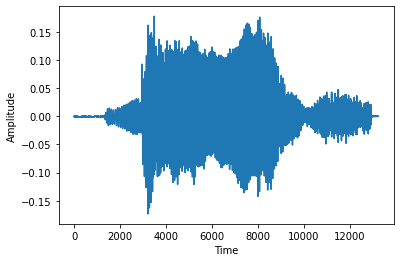

In [18]:
plt.plot(data)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

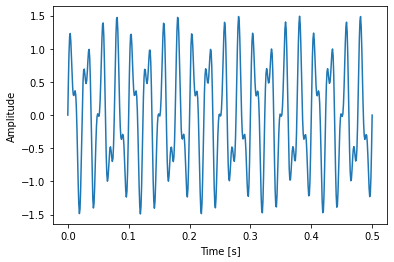

In [19]:
# transpuesta de la matriz 
t = np.linspace(0, 0.5, 500)
#  funcion de enventanado
s = np.sin(40 * 2 * np.pi * t) + 0.5 * np.sin(90 * 2 * np.pi * t)

plt.ylabel("Amplitude")
plt.xlabel("Time [s]")
plt.plot(t, s)
plt.show()

Transformada rapida de fourier y obtencion de las frecuencias mas relevantes.

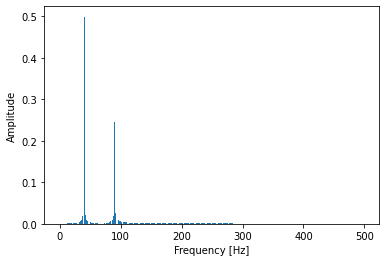

In [20]:
# transformada de fourier

fft = np.fft.fft(s)
T = t[1] - t[0] 
N = s.size

f = np.linspace(0, 1 / T, N)

plt.ylabel("Amplitude")
plt.xlabel("Frequency [Hz]")
plt.bar(f[:N // 2], np.abs(fft)[:N // 2] * 1 / N, width=1.5) 
plt.show()

(40, 26)


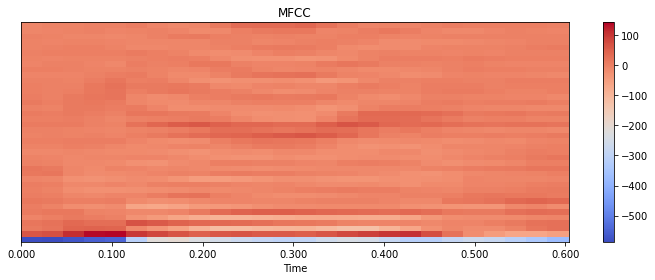

In [21]:
#leer el archivo
y, sr = librosa.load(wav_path)
# obtener los coeficiente ceptrales de frecuencias de MEL
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
print(mfccs.shape)
plt.figure(figsize=(10,4))
librosa.display.specshow(mfccs, x_axis="time")
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

In [22]:
def extract_features_song(file):
  y, sr = librosa.load(file)
  mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
  mfcc /=np.array(np.absolute(mfcc)) # dividir entre una matriz generada a partir de valores absolutos
  return np.ndarray.flatten(mfcc)[:25000] #eliminar multidimensionalidad

In [23]:
import copy
from librosa.util.files import glob
def generate_features_and_labels():
  all_features=[];
  all_labels=[];
  results=[1,2,3];
  for result in results:
    sound_files=glob.glob("./drive/MyDrive/rv_dataset_wav/"+str(result)+"/*.wav");
    #sound_files=glob.glob("./drive/MyDrive/reco_voz_dataset_test/wavs/test/*.wav");
    for file in sound_files:
      features=extract_features_song(file)
      features=features[0:880]
      all_features.append(features);
      all_labels.append(result)
  label_uniq_ids,label_row_ids=np.unique(all_labels,return_inverse=True);
  label_row_ids=label_row_ids.astype(np.int32,copy=False);
  one_hot_labels=to_categorical(label_row_ids,len(label_uniq_ids))
  print(np.stack(all_features))
  print(one_hot_labels)
  return np.stack(all_features),one_hot_labels;

In [166]:
# x e y
x,y=generate_features_and_labels();
print(x.shape)
print(y.shape)

[[-1. -1. -1. ...  1.  1.  1.]
 [-1. -1. -1. ... -1.  1.  1.]
 [-1. -1. -1. ... -1.  1. -1.]
 ...
 [-1. -1. -1. ...  1.  1.  1.]
 [-1. -1. -1. ...  1. -1. -1.]
 [-1. -1. -1. ...  1.  1. -1.]]
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]
(10, 880)
(10, 3)


In [ ]:
featuresTable=pd.DataFrame(data=x);
featuresTable.head()

In [ ]:
labelsTable=pd.DataFrame(data=y);
labelsTable.head() 

In [ ]:
print(x.shape);
print(y.shape);
all_data=np.column_stack((X,y));
table=pd.DataFrame(data=all_data);
table.head()

In [169]:
# funcion de activacion
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

In [170]:
#funcion softmax
def softmax(Z):
    return np.exp(Z) / np.sum(np.exp(Z), axis=1, keepdims=True)

In [171]:
class NeuralNetwork:
    def __init__(self, x, y, nodes_in_layer1 = 880, nodes_in_layer2 = 10, nodes_in_layer3 = 3, l_rate = 0.1):
        
        self.inputs_in_layer0 = x 
        self.y = y
        self.l_rate = l_rate 

        #deficion del numero de neuronas para cada capa
        self.nodes_in_layer1 = nodes_in_layer1
        self.nodes_in_layer2 = nodes_in_layer2
        self.nodes_in_layer3 = nodes_in_layer3
        
        #Inicializacion de los pesos
        self.thetas_layer0 = np.random.rand(self.inputs_in_layer0.shape[1] + 1,self.nodes_in_layer1)  
        self.thetas_layer1 = np.random.rand(self.nodes_in_layer1 + 1,self.nodes_in_layer2)  
        self.thetas_layer2 = np.random.rand(self.nodes_in_layer2+1, nodes_in_layer3) 
 
    def feedforward(self):      
        n = self.inputs_in_layer0.shape[0]
        print("=======valor de n========")
        print(n)

        self.Z1 = self.thetas_layer0[0] + np.dot(self.inputs_in_layer0, self.thetas_layer0[1:])
        print("=======valor de Z1========")
        print(self.Z1)
        self.layer1 = sigmoid(self.Z1)  
        print("=======valor de sigmoide para Z1========")
        print(self.layer1)

        self.Z2 = self.thetas_layer1[0] + np.dot(self.layer1, self.thetas_layer1[1:])
        print("=======valor de Z2========")
        print(self.Z2)
        self.layer2 = sigmoid(self.Z2)  
        print("=======valor de sigmoide para Z2========")
        print(self.layer2)

        self.Z3 = self.thetas_layer2[0] + np.dot(self.layer2, self.thetas_layer2[1:])
        print("=======valor de Z3========")
        print(self.Z3)
        self.layer3 = softmax(self.Z3)   
        print("=======valor de sigmoide para Z3========")
        print(self.layer3)

        return self.layer3
    
    def cost_func(self):
        
        self.n = self.inputs_in_layer0.shape[0] # numero de ejemplos de entrenamiento
        self.cost = (1/self.n) * np.sum(-self.y * np.log(self.layer3)) # entropia cruzada
        return self.cost 

    
    def backprop(self):
        
        self.dE_dZ3 = (1/self.n) * (self.layer3 - self.y)

        self.dE_dtheta2 = np.dot(self.layer2.T, self.dE_dZ3)
        self.dE_dbias2 = np.dot(np.ones(self.n), self.dE_dZ3)

        #derivada del error con respecto a los pesos y el bias de la capa anterior 1
        self.dE_dlayer2 = np.dot(self.dE_dZ3, self.thetas_layer2[1:].T)
        self.dE_dZ2 = np.multiply(self.dE_dlayer2, sigmoid(self.Z2)* (1-sigmoid(self.Z2)))
        self.dE_dtheta1 = np.dot(self.layer1.T, self.dE_dZ2)
        self.dE_dbias1 = np.dot(np.ones(self.n), self.dE_dZ2)
        
        #derivada del error con respecto al peso y al bias de la capa anterior 0
        self.dE_dlayer1 = np.dot(self.dE_dZ2, self.thetas_layer1[1:].T)
        self.dE_dZ1 = np.multiply(self.dE_dlayer1, sigmoid(self.Z1)* (1-sigmoid(self.Z1)))
        self.dE_dtheta0 = np.dot(self.inputs_in_layer0.T, self.dE_dZ1)
        self.dE_dbias0 = np.dot(np.ones(self.n), self.dE_dZ1)

        #actualizacion de los pesos usando el gradiente desendente en las capas 2,1,0
        self.thetas_layer2[1:] = self.thetas_layer2[1:] - self.l_rate * self.dE_dtheta2
        self.thetas_layer1[1:] = self.thetas_layer1[1:] - self.l_rate * self.dE_dtheta1
        self.thetas_layer0[1:] = self.thetas_layer0[1:] - self.l_rate * self.dE_dtheta0
        
        #actualizacion de los bias usando el gradiente desendente en las capas 2,1,0
        self.thetas_layer2[0] = self.thetas_layer2[0] - self.l_rate * self.dE_dbias2
        self.thetas_layer1[0] = self.thetas_layer1[0] - self.l_rate * self.dE_dbias1
        self.thetas_layer0[0] = self.thetas_layer0[0] - self.l_rate * self.dE_dbias0
        
        return self


In [174]:
NN = NeuralNetwork(x,y,nodes_in_layer1=880,nodes_in_layer2 = 30 ,nodes_in_layer3 = 3)
epochs = 1
losses = []
for i in range(epochs):
    predicted_output = NN.feedforward()
    error = NN.cost_func()
    losses.append(error)
    NN.backprop()
    print ("iteration # ", i+1)
    print ("Actual Output: \n", y)
    print("Predicted Output: \n", predicted_output, "\n")
    print ("Cost: \n" , error, "\n")

=======valor de n========
10
=======valor de Z1========
[[-70.02750245 -47.66695949 -57.53916383 ... -43.39765713 -50.10483086
  -54.79412489]
 [-47.94511294 -43.60036507 -57.63981975 ... -47.29970912 -43.73928016
  -43.05231531]
 [-57.41072221 -62.35198312 -58.31910215 ... -51.52836857 -60.60021276
  -57.32134913]
 ...
 [-67.599796   -28.42020345 -39.74782158 ... -37.13602377 -51.1149676
  -40.6556763 ]
 [-40.48983121 -44.63774191 -40.76761302 ... -44.87160323 -42.17655184
  -42.43137542]
 [-11.7403594    2.21554548 -11.78951373 ... -22.06669496 -21.33885676
   -5.99901755]]
=======valor de sigmoide para Z1========
[[3.86760492e-31 1.98839437e-21 1.02579046e-25 ... 1.42114038e-19
  1.73679452e-22 1.59666542e-24]
 [1.50557369e-21 1.16038482e-19 9.27564978e-26 ... 2.87076295e-21
  1.00988515e-19 2.00732192e-19]
 [1.16638021e-25 8.33446632e-28 4.70257518e-26 ... 4.18325045e-23
  4.80465263e-27 1.27542340e-25]
 ...
 [4.38310241e-30 4.54216039e-13 5.46689106e-18 ... 7.44783071e-17
  6.3248

In [ ]:
xTorch = torch.tensor(x, dtype = torch.float)
yTorch = torch.tensor(y, dtype = torch.float)

class Neural_Network(nn.Module):
    def __init__(self, ):
        super(Neural_Network, self).__init__()
        # parametros(capas de la red).
        self.inputSize = 880
        self.outputSize = 1
        self.hiddenSize = 10
        
        # pesos
        self.W1 = torch.randn(self.inputSize, self.hiddenSize) # tensor de 14 X 25
        self.W2 = torch.randn(self.hiddenSize, self.outputSize) # tensor de 25 X 1 
        print("------pesos w1 --------------")
        print(self.W1.shape)
        print("------pesos w2 --------------")
        print(self.W2.shape)

    #fordward propagation
    def forward(self, X):
        # la primera salida sera el resultado de la multiplicacion matricial entre la entrada y los pesos
        self.z = torch.matmul(X, self.W1) # 
        print("capa 1")
        print( self.z )
        # la salida sera alterada por la funcion de activacion sigmoidal
        self.z2 = self.sigmoid(self.z) # activation function
        print("funcion sigmoidal")
        print( self.z2 )
        # la tercera salida sera la multiplicacion matricial de la salida anterior por los nuevos pesos
        self.z3 = torch.matmul(self.z2, self.W2)
        print("capa 3")
        print( self.z3 )
        # la ultima salida (el valor predecido) sera alterada por la funcion de activacion sigmoidal
        o = self.sigmoid(self.z3)
        print("prediccion")
        print(o)        
        return o

    #calculo de la funcion sigmoidal de fordward propagation
    def sigmoid(self, s):
        return 1 / (1 + torch.exp(-s))
    
    #calculo de la derivada de la funcion sigmoidal, para la retropropagacion.
    def sigmoidPrime(self, s):
        return s * (1 - s)
    
    #retropropagacion
    def backward(self, X, y, o):
        # el error es la diferencia del valor obtenido y el esperado.
        self.o_error = y - o 
        # calculo de la influencia de la salida en el error al variar el peso.
        self.o_delta = self.o_error * self.sigmoidPrime(o)
        # calculo de la influencia de la salida en el error al variar el peso.
        self.z2_error = torch.matmul(self.o_delta, torch.t(self.W2))

        self.z2_delta = self.z2_error * self.sigmoidPrime(self.z2)
        #re ajuste de los ultimos pesos
        self.W2 += torch.matmul(torch.t(self.z2), self.o_delta)
        #re ajuste de los pesos anteriores
        self.W1 += torch.matmul(torch.t(X), self.z2_delta)

        
    # entrenamiendo de la red neuronal    
    def train(self, X, y):
        # fordward propagation
        o = self.forward(X)
        # backpropagation
        self.backward(X, y, o)
        
    def saveWeights(self, model):
        # guardado de los pesos con la funcion save de torch
        torch.save(model, "bpnn_saved")
        # el metodo de carga de pesos sera load(ruta_archivo)
        
    # prediccion de los valores, dado una matriz de mismas dimensionalidades.    
    def predict(self):
        print ("Predicted data based on trained weights: ")
        print ("Input (scaled): \n" + str(xPredicted))
        print ("Output: \n" + str(self.forward(xPredicted)))

In [ ]:
model =Sequential([Dense(880,input_dim=np.shape(x)[1]),
Activation("relu"),
Dense(10),
Activation("softmax")])

model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
print(model.summary())

model.fit(x,y,epochs=1,batch_size=1,validation_split=0.2)

loss,acc=model.evaluate(x,y,batch_size=32)

print(loss)
print(acc)

In [ ]:
plt.scatter(range(epochs), losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [32]:
training_split=0.7;
np.random.shuffle(all_data);
splitix=int(len(all_data)*training_split)
train,test=all_data[:splitix,:],all_data[splitix:,:]

In [ ]:
trainInputs=pd.DataFrame(data=train);
trainInputs.head()

,0,1,2,3,4,5,6,7,8,9,...,873,874,875,876,877,878,879,880,881,882
0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,0.0,0.0,1.0
2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,0.0,0.0
3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,0.0,0.0,1.0


In [ ]:
testInputs=pd.DataFrame(data=test);
testInputs.head()

,0,1,2,3,4,5,6,7,8,9,...,873,874,875,876,877,878,879,880,881,882
0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,0.0,0.0


In [ ]:
print(np.shape(train))
print(np.shape(test))

(7, 883)
(3, 883)


In [ ]:
train_input=train[:,:-3];
trainInputs1=pd.DataFrame(data=train_input);
trainInputs1.head()

,0,1,2,3,4,5,6,7,8,9,...,870,871,872,873,874,875,876,877,878,879
0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0
2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0
4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0


In [ ]:
train_labels=train[:,-3:];
trainLabels1=pd.DataFrame(data=train_labels);
trainLabels1.head()

,0,1,2
0,0.0,1.0,0.0
1,0.0,0.0,1.0
2,1.0,0.0,0.0
3,0.0,1.0,0.0
4,0.0,0.0,1.0


In [ ]:
test_input=test[:,:-3];
testInputs1=pd.DataFrame(data=test_input);
testInputs1.head()

,0,1,2,3,4,5,6,7,8,9,...,870,871,872,873,874,875,876,877,878,879
0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0


In [ ]:
test_labels=test[:,-3:];
testLabels1=pd.DataFrame(data=test_labels);
testLabels1.head()

,0,1,2
0,1.0,0.0,0.0
1,0.0,1.0,0.0
2,1.0,0.0,0.0


In [ ]:
import torch, pandas, scipy 
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn as nn
from csv import reader
import pandas as pd

In [ ]:
X,y =generate_features_and_labels();
print(type(X))
print(type(y))

NameError: ignored

In [ ]:
XTable=pd.DataFrame(data=X);
XTable.head()

,0,1,2,3,4,5,6,7,8,9,...,870,871,872,873,874,875,876,877,878,879
0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0
2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0
3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
print(y)

[1, 1, 1, 1, 2, 2, 2, 2, 3, 3]


In [ ]:
#lectura de los datos del archivo csv 
#xy = np.loadtxt('QCM10.csv', delimiter=";", dtype=np.float32, skiprows=1)
#X = xy[:,0:14]
#y = xy[:, [0]]

# data para procesar

#se dividen los datos en entrada(X) y salida esperada(y)
X,y =generate_features_and_labels();
X = torch.tensor(X, dtype = torch.float)
y = torch.tensor(y, dtype = torch.float)
y=y[:,None];

#se genera una matriz de prediccion de los valores de entrada
xPredicted = torch.tensor(X, dtype = torch.float)

#se impriment las variables
print(X.shape)
print(y.shape)

[[-1. -1. -1. ...  1.  1.  1.]
 [-1. -1. -1. ... -1.  1.  1.]
 [-1. -1. -1. ... -1.  1. -1.]
 ...
 [-1. -1. -1. ...  1.  1.  1.]
 [-1. -1. -1. ...  1. -1. -1.]
 [-1. -1. -1. ...  1.  1. -1.]]
[1, 1, 1, 1, 2, 2, 2, 2, 3, 3]
torch.Size([10, 880])
torch.Size([10, 1])


In [ ]:
  #all_features=[];
  #all_labels=[];
  #results=["1","2","3"];
  #for result in results:
  #  sound_files=glob.glob("./drive/MyDrive/reco_voz_dataset_test/wavs/test/*.wav");
  #  print("procesing %d songs in %s number " % (len(sound_files),results))
  #  for file in sound_files:
  #    features=extract_features_song(file)
  #    all_features.append(features);
  #    all_labels.append(result)
  #label_uniq_ids,label_row_ids=np.unique(all_labels,return_inverse=True);
  #label_row_ids=label_row_ids.astype(np.int32,copy=False);
  #one_hot_labels=to_categorical(label_row_ids,len(label_uniq_ids))
  #print(all_features[0].shape)
  #print(one_hot_labels)


The FFT size defines the number of bins used for dividing the window into equal strips, or bins. Hence, a bin is a spectrum sample, and defines the frequency resolution of the window.

By default :

N (Bins) = FFT Size/2

In [ ]:
class Red(nn.Module):
    
    def __init__(self, n_entradas):
        super(Red, self).__init__()
        self.linear1 = nn.Linear(n_entradas, 15)
        self.linear2 = nn.Linear(15, 8)
        # self.linear3 = nn.Linear(8,160)
        # self.linear4 = nn.Linear(160, 200)
        # self.linear5 = nn.Linear(200, 1)
        self.linear3 = nn.Linear(8, 1)
    
    def forward(self, inputs):
        pred_1 = torch.sigmoid(input=self.linear1(inputs))
        pred_2 = torch.sigmoid(input=self.linear2(pred_1))
        # prediction = torch.sigmoid(input=self.linear3(prediction))
        # prediction = torch.sigmoid(input=self.linear4(prediction))
        # prediction = torch.sigmoid(input=self.linear5(prediction))
        pred_f = torch.sigmoid(input=self.linear3(pred_2))
        return pred_f

In [ ]:
%%time
lr = 0.001
epochs = 2000
estatus_print = 100

model = Red(n_entradas=n_entradas)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
print("Arquitectura del modelo: {}".format(model))
historico = pd.DataFrame()

print("Entranando el modelo")
for epoch in range(1, epochs+1):
    y_pred= model(t_X_train)
    loss = loss_fn(input=y_pred, target=t_y_train)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if epoch % estatus_print == 0:
        print(f"\nEpoch {epoch} \t Loss: {round(loss.item(), 4)}")
    
    with torch.no_grad():
        y_pred = model(t_X_test)
        y_pred_class = y_pred.round()
        correct = (y_pred_class == t_y_test).sum()
        accuracy = 100 * correct / float(len(t_y_test))
        if epoch % estatus_print == 0:
            print("Accuracy: {}".format(accuracy.item()))
    
    df_tmp = pd.DataFrame(data={
        'Epoch': epoch,
        'Loss': round(loss.item(), 4),
        'Accuracy': round(accuracy.item(), 4)
    }, index=[0])
    historico = pd.concat(objs=[historico, df_tmp], ignore_index=True, sort=False)

print("Accuracy final: {}".format(round(accuracy.item(), 4)))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 10))
plt.plot(historico['Epoch'], historico['Loss'], label='Loss')
plt.title("Loss", fontsize=25)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid()
plt.show()

In [ ]:
model =Sequential([Dense(100,input_dim=np.shape(train_input)[1]),
Activation("relu"),
Dense(10),
Activation("softmax")])

model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
print(model.summary())

model.fit(train_input,train_labels,epochs=10,batch_size=32,validation_split=0.2)

loss,acc=model.evaluate(test_input,test_labels,batch_size=32)

print(loss)
print(acc)


In [ ]:
# calculo del valor maximo de X
#X_max, _ = torch.max(X, 0)
# calculo del valor maximo de la entrada predecida
#xPredicted_max, _ = torch.max(xPredicted, 0)
# normalizacion de los valores de entrada
#X = torch.div(X, X_max)
# Normalizacion de los valores de entrada predecidos
#xPredicted_max = torch.div(xPredicted, xPredicted_max)
# Normalizacion de los valores de salida
#y = y / 100

#print(xPredicted)
#print("x  normalizado")
#print(X)
#print("----dimensiones de la entrada-----")
#print(X.shape)

#print("----dimensiones de la salida-----")
#print(y.shape)
#print(type(y))